# Diffusion in small-world networks with reflexivity

This code reproduces the diffusion model present in

*Diffusion dynamics in small-world networks with heterogeneous consumers* from Delre, Sebastiano A., Jager, Wander and Janssen, Marco A., Computational and Mathematical Organization Theory, **13**, 2, 2007.

In [128]:
# Necessary libraries

from __future__ import division

import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx

## Auxiliary functions

In [ ]:
def get_neighbors(graph, node, level):
    """Get neighbors of a given node up to a certain level"""
    min_level = int(level)
    if min_level < level:
        max_level = min_level + 1
        percentaje = level - min_level
    else:
        max_level = level
        percentaje = 0
    
    # All neighbors up to max_level
    all_neighbors = nx.single_source_shortest_path_length(graph, node, cutoff=max_level)
    
    if percentaje > 0:
        neighbors_min_level = [k for (k, v) in all_neighbors.items() if (1 <= v <= min_level)]
        neighbors_max_level = [k for (k, v) in all_neighbors.items() if v == max_level]
        n = np.round(len(neighbors_max_level) * percentaje)
        additional_neighbors = random.sample(neighbors_max_level, int(n))
        neighbors = neighbors_min_level + additional_neighbors
    else:
        neighbors = [k for (k, v) in all_neighbors.items() if (1 <= v <= max_level)]
    
    return neighbors

In [4]:
def set_colors(graph):
    """
    Create a list of colors to apply to graph
    
    Adopters are blue and non-adopters are red
    """
    colors = []
    for n in graph.nodes():
        node = G.node[n]
        if node['adopter'] == 1:
            colors.append('b')
        else:
            colors.append('r')
    
    return colors

In [98]:
def is_adopter(graph, node):
        """Return True if a node is an adopter"""
        return graph.node[node]['adopter'] == 1

In [202]:
def draw_graph(graph, node_positions):
    """Function to draw the graph in which the evolution is occurring"""
    nx.draw_networkx_nodes(graph, node_positions, node_color=set_colors(graph), node_size=50)
    nx.draw_networkx_edges(graph, node_positions, width=0.3, alpha=0.5)

In [203]:
def animate(i, graph, node_positions, parameters, test=False):
    """Function to animate the algorithm evolution"""
    #print(i)
    if test:
        node = graph.node[i]
        node['adopter'] = 1
    else:
        evolution_step(graph, parameters)
    draw_graph(graph, node_positions)

In [31]:
def speed_of_difussion(adopters):
    """
    Compute the velocity of diffusion $rho$
    
    This is done according to equation 6 in the article
    """
    T = len(adopters)
    cumulative_adopters = np.cumsum(adopters)
    return (1/T) * ( sum(cumulative_adopters) / sum(adopters) )

## Algorithm

In [255]:
def generate_initial_conditions(number_of_nodes, parameters):
    """
    Initial conditions for the simulation
    
    Create the graph on which the difussion occurs and set additional
    attributes for its node
    
     `parameters` is a dictionary that contains the parameters that control
     the evolution.
    """
    # Network creation.
    # 4 is the average number of neighbors each node has in the graph
    # This number is fixed in the article
    G = nx.generators.watts_strogatz_graph(number_of_nodes, 4,
                                           parameters['randomness'])
    
    for n in G.nodes():
        node = G.node[n]
        node['adopter'] = 0                              # 1 is adopter, 0 non-adopter
        node['preference'] = np.random.random()          # pi
        #node['minimal_utility'] = np.random.random()
        
        # Neighbors never change if the level is an int
        if int(parameters['level']) - parameters['level'] == 0:
            node['neighbors'] = get_neighbors(G, n, parameters['level'])
        else:
            node['neighbors'] = []
    
    return G

In [538]:
def evolution_step(graph, parameters):
    """
    Function that computes the evolution step of the difussion process
    that occurs in a small-world graph
    
    `parameters` is a dictionary that contains the parameters that
    control the evolution.
    """
    
    marketing_effort = parameters['marketing_effort']
    social_threshold = parameters['social_threshold']
    social_influence = parameters['social_influence']
    #minimal_utility = parameters['minimal_utility']
    
    # Adopters before performing the current step
    previous_adopters = [x for x in graph.nodes() if is_adopter(graph, x)]
    
    for n in graph.nodes():
        node = graph.node[n]

        # -- Adoption due to marketing
        p = np.random.random()
        if not node['adopter'] and (p < marketing_effort):
            node['adopter'] = 1

        # -- Adoption due to utility

        # Adopters
        if node['neighbors']:
            neighbors = node['neighbors']
        else:
            neighbors = get_neighbors(graph, n, level=parameters['level'])
        adopters_among_neighbors = [x for x in neighbors if is_adopter(graph, x)]

        # Only if a consumer has adopters among his neighbors, he decides to adopt!
        if len(adopters_among_neighbors) > 0:

            # Ai value
            adopters_percentaje = len(adopters_among_neighbors) / len(neighbors)

            # Computing xi
            if adopters_percentaje > social_threshold:
                local_influence = 1
            else:
                local_influence = 0
            
            # Set individual preference (yi)
            if parameters['quality'] >= node['preference']:
                individual_preference = 1
            else:
                individual_preference = 0

            # Computing utility Ui
            utility = social_influence * local_influence + (1 - social_influence) * individual_preference

            # print(utility)
            #if utility > node['minimal_utility']: #minimal_utility:
            #    if np.random.random() > node['minimal_utility']:
            #        node['adopter'] = 1
            
            minimal_utility = np.random.random()
            if minimal_utility <= utility:
                node['adopter'] = 1
    
    # Return number of adopters at time t
    current_adopters = [x for x in graph.nodes() if is_adopter(graph, x)]
    return len(current_adopters) - len(previous_adopters)

In [331]:
def evolution(graph, parameters, max_time='complete_adoption'):
    """Compute the evolution of the algorithm up to max_time"""
    # Save the adopters at each time during the evolution
    adopters = []
    
    # Perform the evolution
    if max_time == 'complete_adoption':
        while not all( [is_adopter(graph, x) for x in graph.nodes()] ):
            adopters_at_t = evolution_step(graph, parameters)
            adopters.append(adopters_at_t)
    else:
        for t in range(max_time):
            adopters_at_t = evolution_step(graph, parameters)
            adopters.append(adopters_at_t)
    
    return adopters

In [332]:
def compute_run(number_of_times, max_time, number_of_nodes, parameters):
    """
    Compute a run of the algorithm
    
    A run consists in repeating the evolution of the algorithm under
    the same conditions a certain number_of_times
    """
    # Print the parameters of the run
    print(parameters)

    # Perform the run
    speeds = []
    for i in range(number_of_times):
        graph = generate_initial_conditions(number_of_nodes, parameters)
        adopters = evolution(graph, parameters, max_time)
        speed = speed_of_difussion(adopters)
        speeds.append(speed)
    
    return [np.mean(speeds), np.std(speeds)]

## Running the algorithm

These are main parameters that control the evolution of the algorithm, and their corresponding variable in the article:

* Network randomness (`randomness`): $r$
* Quality: $q_{j}$
* Marketing effort: $e_{1}$
* Social influence: $\beta_{j}$
* Social threshold: $h_{i}$
* Minimal utility:  $U_{i, MIN}$
* Level: $L$

In [374]:
parameters = dict(
    randomness = 1,
    quality = 0.5,
    marketing_effort = 0.001,
    social_influence = 1,
    social_threshold = 0.3,
    minimal_utility = 0.5,
    level = 1,
)

In [375]:
compute_run(number_of_times=20,
            max_time=250,
            number_of_nodes=1000,
            parameters=parameters)

{'social_influence': 1, 'randomness': 1, 'level': 1, 'minimal_utility': 0.5, 'quality': 0.5, 'social_threshold': 0.3, 'marketing_effort': 0.001}


[0.83155660000000009, 0.023981681051169018]

## Plots

### 2d plots

In [352]:
# Perform the evolution of a single realization until there is
# complete adoption
G = generate_initial_conditions(1000, parameters)
adopters = evolution(G, parameters)

In [334]:
%matplotlib inline

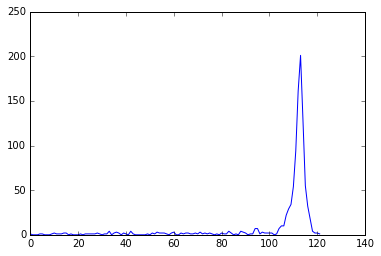

In [353]:
# Plot adopters at each time
plt.plot(adopters)

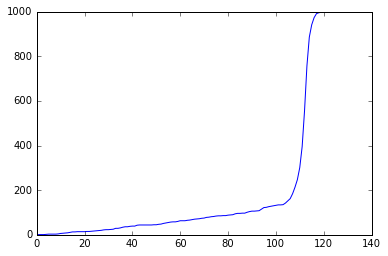

In [354]:
# Plot the cumulative sum of adopters and non-adopters (the usual difussion curve)
plt.plot(np.cumsum(adopters))

In [244]:
# Draw the graph
draw_graph(G, nx.spring_layout(G))

### Animations

In [ ]:
%matplolib qt

In [ ]:
G = generate_initial_conditions(1000, parameters)

In [ ]:
# Plot an animation of the evolution
fig = plt.figure()
positions = nx.spring_layout(G)
animation.FuncAnimation(fig, lambda i: animate(i, G, positions, parameters, test=False),
                        frames=500, interval=3, repeat=False)